# Benchmarks
---

Description:
    TBD
---

## First we import python libraries and set up the directory

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [2]:
from star_pso.population.swarm import Swarm
from star_pso.population.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.utils.auxiliary import cost_function

## Benchmark problems

In [3]:
# Dimensions: 1D
from star_pso.benchmarks.equal_maxima import EqualMaxima
from star_pso.benchmarks.five_uneven_peak_trap import FiveUnevenPeakTrap
from star_pso.benchmarks.uneven_decreasing_maxima import UnevenDecreasingMaxima

# Dimensions: 2D
from star_pso.benchmarks.himmelblau import Himmelblau
from star_pso.benchmarks.six_hump_camel_back import SixHumpCamelBack

# Dimensions: N >= 2D
from star_pso.benchmarks.shubert import Shubert
from star_pso.benchmarks.vincent import Vincent
from star_pso.benchmarks.modified_rastrigin import ModifiedRastrigin

In [4]:
# Create a test problem.
benchmark = UnevenDecreasingMaxima()

## Define the multi-objective function

In [5]:
@cost_function(minimize=False)
def func_benchmark(x_array: np.ndarray, **kwargs) -> float:
    # Return the solution.
    return benchmark.func(x_array).item()
# _end_def_

## Here we set the PSO parameters

- Set the number of particles 'N'
- Setup the initial population
- Create the PSO object

In [6]:
# Get an initial sample.
x_sample = benchmark.initial_random_positions(n_pos=250)

# Initial swarm population.
swarm_t0 = Swarm([Particle(x) for x in x_sample])

# Create the StandardPSO object that will carry on the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0, obj_func = func_benchmark,
                       x_min = benchmark.x_min, x_max = benchmark.x_max)

## Optimization process


| Range of functions | MaxFEs  |
|---|---|
| F1 to F5 (1D or 2D) |  5.0E+04 |
| F6 to F11 (2D) |  2.0E+05 |
|  F6 to F12 (3D or higher) | 4.0E+05  | 

In [7]:
test_PSO.run(max_it = 2500, f_max_eval = 200_000, verbose = True,
             options = {"w0": 0.70, "c1": 1.50, "c2": 1.50, "mode": "multimodal"})

Initial f_optimal = 0.9996
Iteration:     1 -> f_optimal = 0.9484
Iteration:   251 -> f_optimal = 1.0000
Iteration:   501 -> f_optimal = 1.0000
Iteration:   751 -> f_optimal = 1.0000
StandardPSO Reached the maximum number of function evaluations.
Final f_optimal = 1.0000
run: elapsed time = 14.745 seconds.


In [8]:
# Get the optimal solution from the PSO.
_, _, x_opt = test_PSO.get_optimal_values()

# Compute the final objective functions.
f_opt = benchmark.func(x_opt)

# Print the results.
print(f"x={x_opt}, f(x)={f_opt}")

x=[0.07969978], f(x)=[0.99999983]


In [12]:
# Find the global optima.
optimal_particles = benchmark.global_optima_found(test_PSO.swarm.best_n(test_PSO.swarm.size),
                                                  epsilon=1.0e-3, radius=0.01, f_opt=1.0)
print(f"Optimals found = {len(optimal_particles)}")

Optimals found = 1


### Visualize the 1D solutions

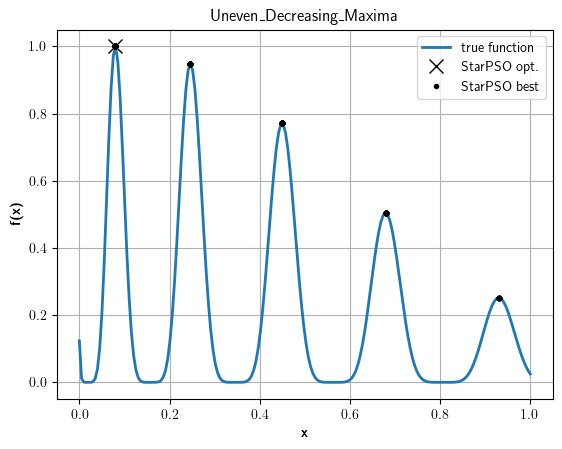

In [10]:
if benchmark.name in {"Equal_Maxima",
                      "Five_Uneven_Peak_Trap",
                      "Uneven_Decreasing_Maxima"}:
    # Extract the best_n particles.
    best_n = []

    # For 1D problems we extract their positions together
    # with their function values.
    for pt in test_PSO.swarm.best_n(test_PSO.swarm.size):
        best_n.append((pt.position.item(), pt.value))
    
    # Convert to numpy array.
    best_n = np.array(best_n)

    # Set a test range.
    x_test = np.linspace(benchmark.x_min, benchmark.x_max, 200)

    # Evaluate the test function.
    f_test = np.array([benchmark.func(xi) for xi in x_test])
    
    # Plot the test function.
    plt.plot(x_test, f_test, '-', linewidth=2, label="true function")
    
    # Plot the optimal PSO.
    plt.plot(x_opt, f_opt, 'kx', markersize=10, label="StarPSO opt.")
    
    # Plot the best_n.
    plt.plot(best_n[:, 0], best_n[:, 1], "k.", label="StarPSO best")
    
    # Set the x/y labels.
    plt.xlabel(r'\textbf{x}')
    plt.ylabel(r'\textbf{f(x)}')
    plt.title(benchmark.name)
    
    # Final set up.
    plt.grid(True)
    plt.legend()
    plt.show();

### Visualize the 2D solutions

In [11]:
if benchmark.name in {"Himmelblau",
                      "Shubert_2D",
                      "Vincent_2D",
                      "Rastrigin_2D",
                      "Six_Hump_Camel_Back"}:
    # Extract the best_n particles.
    best_n = []

    # For 2D problems we extract only their positions.
    for pt in test_PSO.swarm.best_n(test_PSO.swarm.size):
        best_n.append(pt.position)
    
    # Convert to numpy array.
    best_n = np.array(best_n)

    # Sample sizes.
    nx, ny = 200, 200
    
    # Set a test range.
    if np.isscalar(benchmark.x_min):
        x_test = np.linspace(benchmark.x_min, benchmark.x_max, nx)
        y_test = np.linspace(benchmark.x_min, benchmark.x_max, ny)
        
    else:
        x_test = np.linspace(benchmark.x_min[0], benchmark.x_max[0], nx)
        y_test = np.linspace(benchmark.x_min[1], benchmark.x_max[1], ny)
        
    # Make the meshgrid for the contour plot.
    xv, yv = np.meshgrid(x_test, y_test)

    # Combine the x_test, y_test.
    pos = np.array([(xi, yi) for xi in x_test for yi in y_test])
    
    # Compute the function values.
    f_test = np.array([benchmark.func(p) for p in pos])
    
    # First plot the contour of the "true" function.
    plt.contour(xv, yv, f_test.reshape(nx, ny).T, levels=40)
    
    # Plot the optimal PSO.
    plt.plot(x_opt[0], x_opt[1], "kx", markersize=12, label="StarPSO optimal")
    
    # Plot the best_n.
    plt.plot(best_n[:, 0], best_n[:, 1], "ko", alpha=0.5, markersize=5, label="StarPSO particles")
    
    # Add labels.
    plt.xlabel("$x$", fontsize=14)
    plt.ylabel("$y$", fontsize=14)
    plt.title(benchmark.name, fontsize=14)
    plt.legend()
    
    # Final setup.
    plt.colorbar()
    plt.grid()

    # Save to file.
    plt.savefig(f"{benchmark.name}.pdf", format="pdf", dpi=300)

### End of file